In [14]:
import numpy as np
import scipy as sci
import pandas as pd
import ipaddress
import re

from collections import defaultdict, Counter
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from bokeh.plotting import figure, show, output_notebook
from bokeh.charts import *
output_notebook()

from geopy.distance import vincenty

from sqlalchemy import create_engine, text, func, or_, and_, not_, distinct, between, extract
from sqlalchemy.orm import sessionmaker, aliased
from sqlalchemy.pool import NullPool

from model.Base import Base
from model.User import User
from model.Device import Device
from model.DeviceTraffic import DeviceTraffic
from model.DeviceAppTraffic import DeviceAppTraffic
from model.DeviceAppTraffic2 import DeviceAppTraffic2
from model.Flow import Flow
from model.HttpReq import HttpReq
from model.DnsReq import DnsReq
from model.DnsReqSimple import DnsReqSimple
from model.Location import Location
from model.UserLocation import UserLocation
from model.user_devices import user_devices
from model.UrlCategory import UrlCategory

import datautils

DB='postgresql+psycopg2:///ucnstudy'

engine = create_engine(DB, echo=False, poolclass=NullPool)
Base.metadata.bind = engine
Session = sessionmaker(bind=engine)

sns.set(style="whitegrid", context="paper", font_scale=1.5)
palette = sns.light_palette("grey", n_colors=8, reverse=True)
revpalette = sns.light_palette("grey", n_colors=8, reverse=False)
sns.set_palette(palette)
sns.set_color_codes()

cmap = sns.light_palette("grey", as_cmap=True)

Loading BokehJS ...

# Automatic Profiling

A user profile is defined to consist of three elements:

- location (moves i.e. accurate geo-location, or replace with IP-based location)
- time-of-day + weekday (always known)
- content/interests (http(s) URLs, domains, categories)

We can have this data at different levels:

- per user (i.e. combine data from all user devices)
- per device
- per user-agent

## Per Element

In the first step, we will consider each profile element in isolation

### Location

Study moves vs IP based geo-location => nobody did this for end-user devices so far ?

Unique locations, number of visits, total visit time per user, device or user-agent (assuming perfect IP location)

### Time-of-Day

Time slot coverage at different levels i.e. how much daily patterns do we loose ?

### Content

Unique content, number of visits at different levels i.e. how much content patterns do we loose ?

## Pair-wise

More interesting patterns arise as a combination of the individual elements, and we well lack more details when only partial data is available

### Location vs time-of-day

### Content vs time-of-day

### Content vs location


## Full profile

Finally, quantify somehow changes in the full profile as a function of data availability ...

In [2]:
# Content basics (identifying https using DNS)
ses = Session()

allflows = {}
q = ses.query(Flow.dstport, 
              func.count(Flow.startts).label('flows'), 
              func.sum(Flow.bytes_in+Flow.bytes_out).label('bytes')).group_by(Flow.dstport).order_by('flows desc')
for (port,flows,bytes) in q.limit(20):
    allflows[port] = flows
    print port, flows, bytes

# % of flows to ports 80|443 for which we know the DNS req (i.e. domain)
q = """SELECT f.startts, 
              (SELECT d.ts FROM dnsreqssimple d WHERE 
                  d.devid = f.devid AND 
                  d.ans_addr = f.dstip AND
                  d.ts <= f.startts AND
                  f.startts < d.ts + d.ans_ttl * interval '1 second' ORDER BY d.ts DESC LIMIT 1) AS dnsts
       FROM flows f WHERE f.dstport=80"""
match80 = 0
for row in ses.execute(text(q)):
    if (row[1]!=None):
        match80+=1
        
q = """SELECT f.startts, 
              (SELECT d.ts FROM dnsreqssimple d WHERE 
                  d.devid = f.devid AND 
                  d.ans_addr = f.dstip AND
                  d.ts <= f.startts AND
                  f.startts < d.ts + d.ans_ttl * interval '1 second' ORDER BY d.ts DESC LIMIT 1) AS dnsts
       FROM flows f WHERE f.dstport=443"""
match443 = 0
for row in ses.execute(text(q)):
    if (row[1]!=None):
        match443+=1
        
print 'matched HTTP flows',match80,100.0*(float(match80)/allflows[80])
print 'matched HTTPS flows',match443,100.0*(float(match443)/allflows[443])
        
ses.close()

/home/apietila/work/dataprojects/venv/local/lib/python2.7/site-packages/sqlalchemy/sql/compiler.py:575: SAWarning: Can't resolve label reference 'flows desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


80 1127116 12725133964
53 378635 98347390
443 305355 32416741177
5431 18343 36421471
5355 17514 1821647
3702 12894 17895057
993 5160 187546963
389 4087 17223293
5223 3098 12277466
8008 2768 283360
1900 2484 14960367
137 1485 3711383
138 1452 949266
7676 1437 12284870
1400 1237 128900
123 876 147692
88 846 3707283
2054 845 64232
5228 779 3929241
110 777 10256471
matched HTTP flows 1002548 88.9480763293
matched HTTPS flows 235584 77.150857199


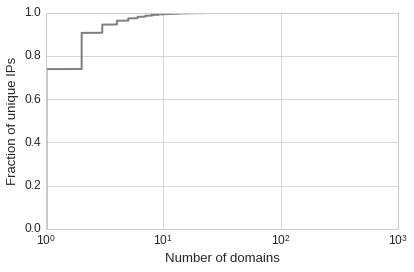

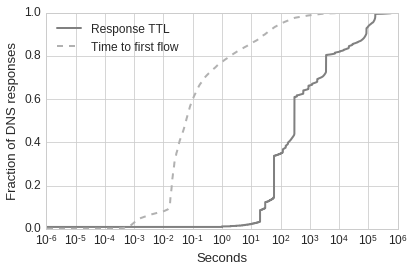

In [3]:
# About DNS reqs
ses = Session()

revmapping = defaultdict(set)
q = ses.query(DnsReq.query_domain, DnsReq.ans_addr).filter(DnsReq.query_domain!=None)
for row in q.all():
    for a in row[1]:
        if (a==None or len(a)<=1):
            continue
        revmapping[a].add(row[0].lower())
        
# 1-to-1 mapping IP to host ? not true ..
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

hcount = [len(d) for (a,d) in revmapping.iteritems()]
(x,y) = datautils.aecdf(hcount)
ax1.plot(x,y, '-', lw=2, color=palette[0])

ax1.set_ylabel('Fraction of unique IPs')
ax1.set_xlabel('Number of domains')
ax1.set_xscale('log')
plt.tight_layout()
plt.show()    
f.savefig("../figsimc/dns_iptodomain_cdf.eps")

# CDF of time to first byte + TTL
q = """SELECT d.ans_ttl AS ttl, 
              d.ts AS dnsts, 
              (SELECT f.startts FROM flows f WHERE 
                  f.devid = d.devid AND 
                  f.dstip = d.ans_addr AND
                  f.startts >= d.ts AND 
                  f.startts < d.ts + d.ans_ttl * interval '1 second' ORDER BY f.startts LIMIT 1) AS flowts 
       FROM dnsreqssimple d WHERE NOT d.ans_ttl IS NULL AND NOT d.ans_addr IS NULL AND d.user_req = 't'"""

ttls = []
firstb = []
for (ttl, dnsts, flowts) in ses.execute(text(q)):
    ttls.append(ttl)
    
    if (flowts != None):
        firstb.append((flowts-dnsts).total_seconds())
        
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(ttls)
ax1.plot(x,y, '-', lw=2, color=palette[0], label="Response TTL")

(x,y) = datautils.aecdf(firstb)
ax1.plot(x,y, '--', lw=2, color=palette[3], label="Time to first flow")

ax1.set_ylabel('Fraction of DNS responses')
ax1.set_xlabel('Seconds')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()    
f.savefig("../figsimc/dns_delay_cdf.eps")

ses.close()

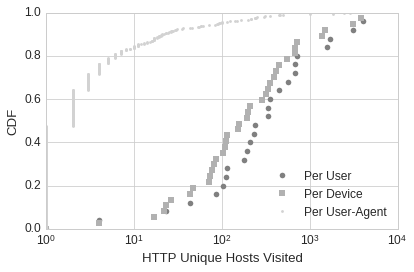

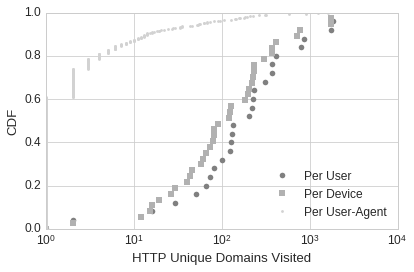

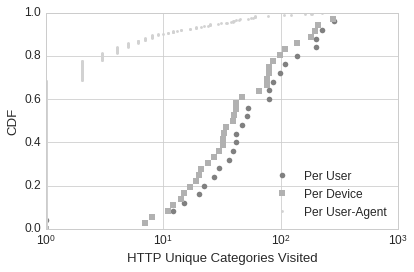

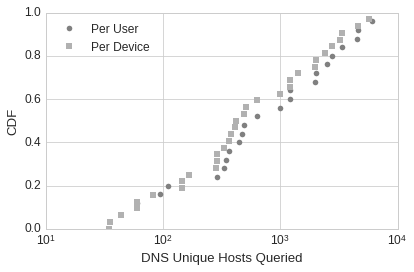

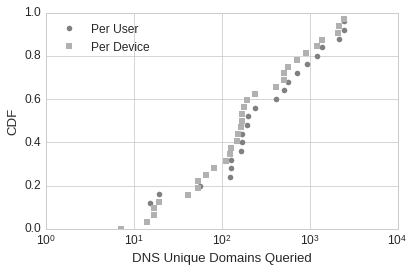

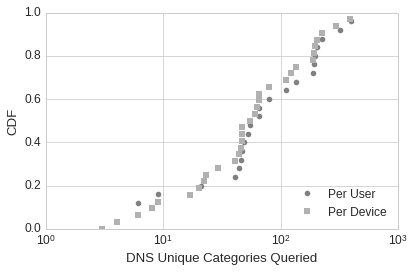

In [7]:
# Content Analysis
ses = Session()

user = defaultdict(list)
dev = defaultdict(list)
ua = defaultdict(list)

alldevs = []

for u in ses.query(User):
    devs = [d.id for d in u.devices if not d.shared]
    alldevs += devs

    # unique HTTP(S) hosts|domains|cats for this user
    user['host'].append(ses.query(
            func.count(distinct(HttpReq.req_url_host))).filter(HttpReq.devid.in_(devs), HttpReq.user_url==True).scalar())
    user['domain'].append(ses.query(
            func.count(distinct(HttpReq.req_url_domain))).filter(HttpReq.devid.in_(devs), HttpReq.user_url==True).scalar())
    user['cat'].append(ses.query(
            func.count(distinct(UrlCategory.main_category))).filter(
            UrlCategory.domain==HttpReq.req_url_domain, HttpReq.devid.in_(devs), HttpReq.user_url==True).scalar())    

    user['dnshost'].append(ses.query(
            func.count(distinct(DnsReq.query))).filter(DnsReq.devid.in_(devs), DnsReq.user_req==True).scalar())
    user['dnsdomain'].append(ses.query(
            func.count(distinct(DnsReq.query_domain))).filter(DnsReq.devid.in_(devs), DnsReq.user_req==True).scalar())
    user['dnscat'].append(ses.query(
            func.count(distinct(UrlCategory.main_category))).filter(
            UrlCategory.domain==DnsReq.query_domain, DnsReq.devid.in_(devs), DnsReq.user_req==True).scalar())    
    
    
# unique HTTP hosts|domains|cats per device
q = ses.query(HttpReq.devid, func.count(distinct(HttpReq.req_url_host))).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True).group_by(HttpReq.devid)
for (d,cnt) in q.all():
    dev['host'].append(cnt)
        
q = ses.query(HttpReq.devid, func.count(distinct(HttpReq.req_url_domain))).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True).group_by(HttpReq.devid)
for (d,cnt) in q.all():
    dev['domain'].append(cnt)

q = ses.query(HttpReq.devid, func.count(distinct(UrlCategory.main_category))).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True, UrlCategory.domain==HttpReq.req_url_domain).group_by(HttpReq.devid)
for (d,cnt) in q.all():
    dev['cat'].append(cnt)

# unique HTTP hosts|domains|cats per user-agent
q = ses.query(HttpReq.req_ua, func.count(distinct(HttpReq.req_url_host))).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True, HttpReq.req_ua!=None).group_by(HttpReq.req_ua)
for (d,cnt) in q.all():
    ua['host'].append(cnt)

q = ses.query(HttpReq.req_ua, func.count(distinct(HttpReq.req_url_domain))).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True, HttpReq.req_ua!=None).group_by(HttpReq.req_ua)
for (d,cnt) in q.all():
    ua['domain'].append(cnt)

q = ses.query(HttpReq.req_ua, func.count(distinct(UrlCategory.main_category))).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True, UrlCategory.domain==HttpReq.req_url_domain, HttpReq.req_ua!=None).group_by(HttpReq.req_ua)
for (d,cnt) in q.all():
    ua['cat'].append(cnt)   

    
# unique DNS hosts|domains|cats per device
q = ses.query(DnsReq.devid, func.count(distinct(DnsReq.query))).filter(
    DnsReq.devid.in_(alldevs), DnsReq.user_req==True).group_by(DnsReq.devid)
for (d,cnt) in q.all():
    dev['dnshost'].append(cnt)
        
q = ses.query(DnsReq.devid, func.count(distinct(DnsReq.query_domain))).filter(
    DnsReq.devid.in_(alldevs), DnsReq.user_req==True).group_by(DnsReq.devid)
for (d,cnt) in q.all():
    dev['dnsdomain'].append(cnt)

q = ses.query(DnsReq.devid, func.count(distinct(UrlCategory.main_category))).filter(
    DnsReq.devid.in_(alldevs), DnsReq.user_req==True, UrlCategory.domain==DnsReq.query_domain).group_by(DnsReq.devid)
for (d,cnt) in q.all():
    dev['dnscat'].append(cnt)
    
    
# per user/device/UA unique HTTP hosts|domains|categories
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['host'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['host'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

(x,y) = datautils.aecdf(ua['host'])
ax1.plot(x,y, '.', lw=2, color=palette[5], label="Per User-Agent")

ax1.set_ylabel('CDF')
ax1.set_xlabel('HTTP Unique Hosts Visited')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_unique_http_host_cdf.eps")

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['domain'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['domain'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

(x,y) = datautils.aecdf(ua['domain'])
ax1.plot(x,y, '.', lw=2, color=palette[5], label="Per User-Agent")

ax1.set_ylabel('CDF')
ax1.set_xlabel('HTTP Unique Domains Visited')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_unique_http_domain_cdf.eps")

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['cat'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['cat'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

(x,y) = datautils.aecdf(ua['cat'])
ax1.plot(x,y, '.', lw=2, color=palette[5], label="Per User-Agent")

ax1.set_ylabel('CDF')
ax1.set_xlabel('HTTP Unique Categories Visited')
ax1.set_xscale('log')
ax1.legend(loc='lower right')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_unique_http_cat_cdf.eps")

# per user/device DNS unique hosts|domains|categories
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['dnshost'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['dnshost'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

ax1.set_ylabel('CDF')
ax1.set_xlabel('DNS Unique Hosts Queried')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_unique_dns_host_cdf.eps")

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['dnsdomain'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['dnsdomain'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

ax1.set_ylabel('CDF')
ax1.set_xlabel('DNS Unique Domains Queried')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_unique_dns_domain_cdf.eps")

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['dnscat'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['dnscat'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

ax1.set_ylabel('CDF')
ax1.set_xlabel('DNS Unique Categories Queried')
ax1.set_xscale('log')
ax1.legend(loc='lower right')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_unique_dns_cat_cdf.eps")

ses.close()

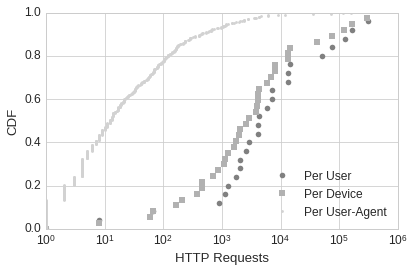

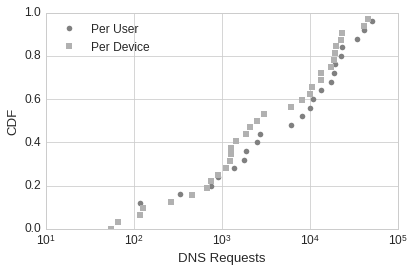

In [6]:
# Content Analysis
ses = Session()

user = defaultdict(list)
dev = defaultdict(list)
ua = defaultdict(list)

alldevs = []

for u in ses.query(User):
    devs = [d.id for d in u.devices if not d.shared]
    alldevs += devs

    user['host'].append(ses.query(
            func.count(HttpReq.ts)).filter(HttpReq.devid.in_(devs), HttpReq.user_url==True).scalar())

    user['dnshost'].append(ses.query(
            func.count(DnsReq.ts)).filter(DnsReq.devid.in_(devs), DnsReq.user_req==True).scalar())
    
q = ses.query(HttpReq.devid, func.count(HttpReq.ts)).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True).group_by(HttpReq.devid)
for (d,cnt) in q.all():
    dev['host'].append(cnt)

q = ses.query(HttpReq.req_ua, func.count(HttpReq.ts)).filter(
    HttpReq.devid.in_(alldevs), HttpReq.user_url==True, HttpReq.req_ua!=None).group_by(HttpReq.req_ua)
for (d,cnt) in q.all():
    ua['host'].append(cnt)
    
q = ses.query(DnsReq.devid, func.count(DnsReq.ts)).filter(
    DnsReq.devid.in_(alldevs), DnsReq.user_req==True).group_by(DnsReq.devid)
for (d,cnt) in q.all():
    dev['dnshost'].append(cnt)
    
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['host'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['host'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

(x,y) = datautils.aecdf(ua['host'])
ax1.plot(x,y, '.', lw=2, color=palette[5], label="Per User-Agent")

ax1.set_ylabel('CDF')
ax1.set_xlabel('HTTP Requests')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_http_reqs_cdf.eps")

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(user['dnshost'])
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User")

(x,y) = datautils.aecdf(dev['dnshost'])
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per Device")

ax1.set_ylabel('CDF')
ax1.set_xlabel('DNS Requests')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/content_dns_reqs_cdf.eps")

ses.close()

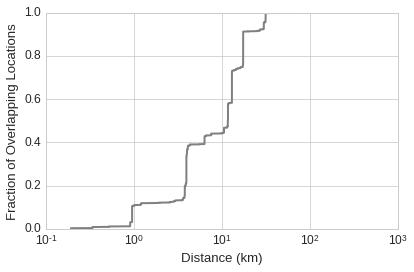

moves vs other city match 2343 37.0200663612
moves vs other street match 0 0.0


In [8]:
# Location basics (moves vs IP based)
ses = Session()

devs = ses.query(Device.id).filter(Device.shared==False).all()

loc1 = aliased(Location)
loc2 = aliased(Location)
q = ses.query(loc1,loc2).filter(
    loc1.source=='moves', 
    loc2.source!='moves',
    loc1.devid==loc2.devid,
    loc1.devid.in_(devs),
    loc1.entertime<=loc2.entertime,
    loc1.exittime>=loc2.exittime)

dist = []
samecity = 0
samestreet = 0

for (loc1,loc2) in q.all():
    d = vincenty((loc1.lat,loc1.lon), (loc2.lat,loc2.lon)).kilometers
    dist.append(d)
    
    if (loc1.city == loc2.city and loc1.city != None):
        samecity += 1
        
    if (loc1.street == loc2.street and loc1.street != None):
        samestreet += 1
    

# CDF of distances
f, ax1 = plt.subplots(1, 1, figsize=(6,4))
(x,y) = datautils.aecdf(dist)
ax1.plot(x,y, '-', lw=2)
ax1.set_ylabel('Fraction of Overlapping Locations')
ax1.set_xlabel('Distance (km)')
ax1.set_xscale('log')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/location_movesvsip_cdf.eps")

print 'moves vs other city match',samecity,100.0*(samecity*1.0/len(dist))
print 'moves vs other street match',samestreet,100.0*(samestreet*1.0/len(dist))

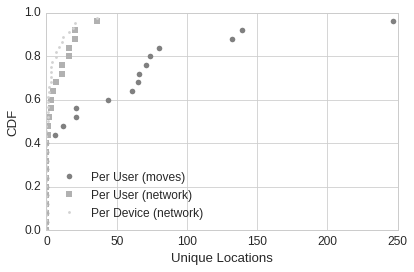

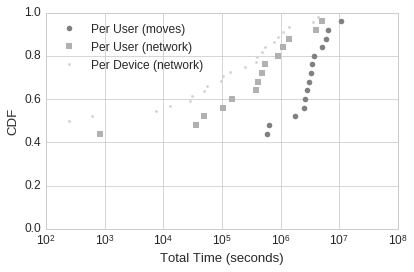

In [11]:
# Location Analysis (assume IP loc is available and perfect, use moves)
ses = Session()

movesloc = []  # unique moves locations per user
userloc = []   # unique moves locations per user (when online)
devloc = []    # unique moves locations per device (when online) 
movestime = [] # total time per unique loc per user
usertime = []  # "-"
devtime = []   # "-"

for u in ses.query(User):
    devs = [d.id for d in u.devices if not d.shared]
    
    movesloc.append(ses.query(func.count(distinct(Location.name))).filter(
            Location.devid.in_(devs), Location.source=='moves').scalar())

    q = ses.query(Location.exittime-Location.entertime).filter(
            Location.devid.in_(devs), Location.source=='moves')
    t = 0
    for row in q.all():
        t += row[0].total_seconds()
    movestime.append(t)

    q = ses.query(DeviceAppTraffic, Location.name).filter(
            DeviceAppTraffic.devid.in_(devs), 
            Location.devid.in_(devs), 
            Location.source=='moves',
            DeviceAppTraffic.ts>=Location.entertime, 
            DeviceAppTraffic.ts<Location.exittime)
    
    usertr = defaultdict(int)
    devtr = {}
    for d in devs:
        devtr[d] = defaultdict(int)
        
    for (tr,n) in q.all():
        if (n == None):
            continue
        usertr[n] += 10
        devtr[tr.devid][n] += 10
        
    userloc.append(len(usertr))
    usertime.append(sum(usertr.values()))
    
    for d in devs:
        devloc.append(len(devtr[d]))
        devtime.append(sum(devtr[d].values()))
        
# unique locations per user, device
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(movesloc)
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User (moves)")

(x,y) = datautils.aecdf(userloc)
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per User (network)")

(x,y) = datautils.aecdf(devloc)
ax1.plot(x,y, '.', lw=2, color=palette[5], label="Per Device (network)")

ax1.set_ylabel('CDF')
ax1.set_xlabel('Unique Locations')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/location_unique_cdf.eps")

# time spent in unique locations per user, device
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(movestime)
ax1.plot(x,y, 'o', lw=2, color=palette[0], label="Per User (moves)")

(x,y) = datautils.aecdf(usertime)
ax1.plot(x,y, 's', lw=2, color=palette[3], label="Per User (network)")

(x,y) = datautils.aecdf(devtime)
ax1.plot(x,y, '.', lw=2, color=palette[5], label="Per Device (network)")

ax1.set_ylabel('CDF')
ax1.set_xlabel('Total Time (seconds)')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/location_time_cdf.eps")

ses.close()

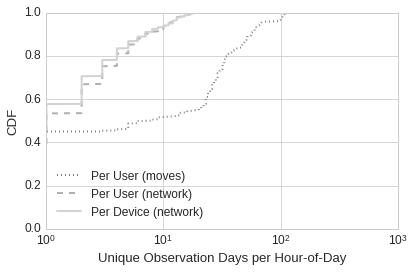

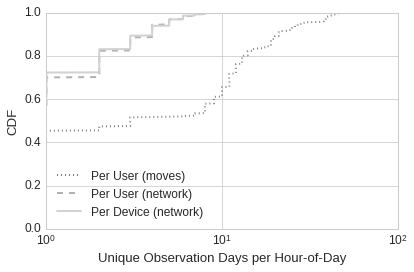

In [18]:
# Time-of-day Analysis (coverage as a function of tracking)
ses = Session()

weekdaysmoves = []
weekendmoves = []
weekdaysuser = []
weekenduser = []
weekdaysdev = []
weekenddev = []

for u in ses.query(User):
    devs = [d.id for d in u.devices if not d.shared]
    
    # get moves locs and count unique days per bin
    week = defaultdict(int)
    we = defaultdict(int)
    q = ses.query(Location.entertime, Location.exittime).filter(
        Location.devid.in_(devs), Location.source=='moves')
    for (start,end) in q.all():        
        while (start <= end):
            if (start.weekday() in [5,6]):
                we[start.hour] += 1
            else:
                week[start.hour] += 1
            start += timedelta(seconds=3600)
    for i in range(24):
        weekdaysmoves.append(week[i])
    for i in range(24):
        weekendmoves.append(we[i])
        
    # get network traffic and count unique days per bin
    week = defaultdict(int)
    we = defaultdict(int)
    
    q = ses.query(
            func.DATE(DeviceAppTraffic.ts).label('date'), 
            extract('hour', DeviceAppTraffic.ts).label('h')).filter(DeviceAppTraffic.devid.in_(devs))
    for (date,h) in q.distinct():        
        if (date.weekday() in [5,6]):
            we[h] += 1
        else:
            week[h] += 1
            
    for i in range(24):
        weekdaysuser.append(week[i])
    for i in range(24):
        weekenduser.append(we[i])
    
    # same per device
    week = defaultdict(int)
    we = defaultdict(int)
    
    for d in devs:
        q = ses.query(
                func.DATE(DeviceAppTraffic.ts).label('date'), 
                extract('hour', DeviceAppTraffic.ts).label('h')).filter(DeviceAppTraffic.devid == d)
        for (date,h) in q.distinct():        
            if (date.weekday() in [5,6]):
                we[h] += 1
            else:
                week[h] += 1

        for i in range(24):
            weekdaysdev.append(week[i])
        for i in range(24):
            weekenddev.append(we[i])
    
ses.close()


f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(weekdaysmoves)
ax1.plot(x,y, ':', lw=2, color=palette[0], label="Per User (moves)")

(x,y) = datautils.aecdf(weekdaysuser)
ax1.plot(x,y, '--', lw=2, color=palette[3], label="Per User (network)")

(x,y) = datautils.aecdf(weekdaysdev)
ax1.plot(x,y, '-', lw=2, color=palette[5], label="Per Device (network)")

ax1.set_ylabel('CDF')
ax1.set_xlabel('Unique Observation Days per Hour-of-Day')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/hourofday_week_visits_cdf.eps")


f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(weekendmoves)
ax1.plot(x,y, ':', lw=2, color=palette[0], label="Per User (moves)")

(x,y) = datautils.aecdf(weekenduser)
ax1.plot(x,y, '--', lw=2, color=palette[3], label="Per User (network)")

(x,y) = datautils.aecdf(weekenddev)
ax1.plot(x,y, '-', lw=2, color=palette[5], label="Per Device (network)")

ax1.set_ylabel('CDF')
ax1.set_xlabel('Unique Observation Days per Hour-of-Day')
ax1.set_xscale('log')
ax1.legend(loc='best')
plt.tight_layout()
plt.show()
f.savefig("../figsimc/hourofday_weekend_visits_cdf.eps")

norelie
	norelie.pcnono 2
salmita
	salmita.iphone 70
jasivan
	jasivan.laptop 4
carmelia
	carmelia.laptop 14
sormain
	sormain.laptop 20
	sormain.phone 21
francois
	francois.netbook 6
bencardino
	bencardino.ipad 30
	bencardino.iphone 49
shelter
	shelter.iphone 43
	shelter.macbook 42
desir
	desir.phone 2
filiatre
	filiatre.iphone 27
majid
	majid.android 26
neenagupta
	neenagupta.workpc 0
	neenagupta.macair 20
	neenagupta.iphone 16
chrismaley
	chrismaley.mainpc 0
	chrismaley.loungepc 0
clifford.wife
	clifford.mainlaptop 0
	clifford.rachelphone 50
	clifford.rachelipad 27
clifford.husband
	clifford.aidanlaptop 27
	clifford.aidanphone 12
kemianny
	kemianny.mainlaptop 0
barnesldavid.wife
	barnesldavid.tablet 22
barnesldavid.husband
	barnesldavid.phone 22
michaelbrogan
	michaelbrogan.laptop 61
harrison
	harrison.tablet 17
	harrison.phone 7
gluch
	gluch.laptop 0
	gluch.phone 9
bowen.wife
	bowen.iphone 37
bowen.husband
	bowen.iphonedominic 87
bridgeman.wife
	bridgeman.laptop2 0
	bridgeman.iphonej

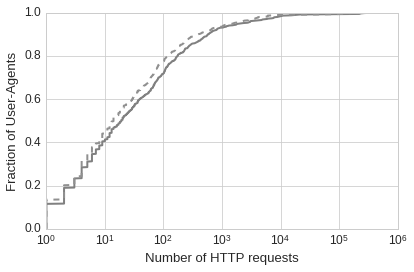

In [7]:


#urlcat = defaultdict(str)
#for (c,d) in ses.query(UrlCategory.main_category, UrlCategory.domain).all():
#    urlcat[d] = c


# get all http reqs with category (+ user url)
#httpreqs = ses.query(HttpReq.ts, HttpReq.req_url_domain, UserLocation.name).filter(
#    HttpReq.devid.in_(devs), 
#    HttpReq.user_url==True, 
#    HttpReq.req_url_domain!=None,
#    UserLocation.entertime<=HttpReq.ts, 
#    UserLocation.exittime>HttpReq.ts, 
#    UserLocation.uid==userid).order_by(HttpReq.ts).all()
#
#dnsreqs = ses.query(DnsReq.ts, DnsReq.query_domain, UserLocation.name).filter(
#    DnsReq.devid.in_(devs), 
#    DnsReq.user_req==True, 
#    DnsReq.query_domain!=None,
#    DnsReq.duplicate==False, 
#    UserLocation.entertime<=DnsReq.ts, 
#    UserLocation.exittime>DnsReq.ts, 
#    UserLocation.uid==userid).order_by(DnsReq.ts).all()
#
#combined = [(urlcat[t[1]],t[1],t[0].hour,('weekend' if t[0].weekday() in [5,6] else 'week'), t[2]) for t in httpreqs if urlcat[t[1]].find('advertising')<0]
#combined += [(urlcat[t[1]],t[1],t[0].hour,('weekend' if t[0].weekday() in [5,6] else 'week'), t[2]) for t in dnsreqs if urlcat[t[1]].find('advertising')<0]
#
#c = Counter(combined)
#for t in c.most_common(100):
#    print t
#
#print '------------------'
#combined2 = [(urlcat[t[1]],t[0].hour,('weekend' if t[0].weekday() in [5,6] else 'week'), t[2]) for t in httpreqs if urlcat[t[1]].find('advertising')<0]
#combined2 += [(urlcat[t[1]],t[0].hour,('weekend' if t[0].weekday() in [5,6] else 'week'), t[2]) for t in dnsreqs if urlcat[t[1]].find('advertising')<0]

#c = Counter(combined2)
#for t in c.most_common(100):
#    print t



In [ ]:
        
# => unique domains, categories, locations, times-of-day, total online time, bytes per user, per device(s), per user agent(s)


# => unique domains, categories, bytes, flows, etc per user, device, UA if have / do not have DNS
